In [25]:
import pandas as pd
import numpy as np
from spellchecker import SpellChecker
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
% matplotlib inline

In [2]:
#loading the dataset
dsChallengeDF = pd.read_csv("B:/user-ct-test-collection-02.txt", sep = '\t')

In [3]:
dsChallengeDF.head()

,AnonID,Query,QueryTime,ItemRank,ClickURL
0,479,family guy,2006-03-01 16:01:20,NaN,NaN
1,479,also sprach zarathustra,2006-03-02 14:48:55,NaN,NaN
2,479,family guy movie references,2006-03-03 22:37:46,1.0,http://www.familyguyfiles.com
3,479,top grossing movies of all time,2006-03-03 22:42:42,1.0,http://movieweb.com
4,479,top grossing movies of all time,2006-03-03 22:42:42,2.0,http://www.imdb.com


In [11]:
#Data Preprocessing
dsChallengeDF = dsChallengeDF.drop_duplicates(subset = ['AnonID','Query','QueryTime','ItemRank', 'ClickURL'], keep = 'first')
print(dsChallengeDF.shape)

(3451202, 11)


In [12]:
#formatting date time field
dsChallengeDF['QueryTime'] = pd.to_datetime(dsChallengeDF['QueryTime'])

In [13]:
#Feature Engineering Methods

#Creation of Weekday from QueryTime
weekdayTuple = ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday')
def weekday(x):
   return weekdayTuple[x]

dsChallengeDF['weekday'] = dsChallengeDF['QueryTime'].dt.weekday
dsChallengeDF['weedkayCorrected'] = dsChallengeDF['weekday'].apply(lambda row: weekday(row))

In [14]:
#Creation of Time of the day from QueryTime

def timeOfDay(x):
    if x>6 and x<=11:
        return "morning"
    elif x>11 and x <15:
        return "afternoon"
    elif x>=15 and x <=20:
        return "evening"
    else: 
        return "night"
    
dsChallengeDF['TimeOfDay'] = dsChallengeDF['QueryTime'].dt.hour.apply(lambda row: timeOfDay(row))    

In [15]:
#Creation of a column with Number of words in the query as values

def numOfWords(x):
   return len(x.split())
    
dsChallengeDF['NumOfWords'] = dsChallengeDF['Query'].apply(lambda row: numOfWords(row))    

In [16]:
#Creation of a column for Click - 0 - If the user hasn't clicked, 1 otherwise

dsChallengeDF['Click'] = np.where(dsChallengeDF['ItemRank'].isnull(),0,1)


In [17]:
#Creation of a column to indicate spelling mistakes in query search
spell = SpellChecker()
def spellChecker(x):
    misspelled = spell.unknown(x)
    if misspelled:
        return 0
    else:
        return 1


dsChallengeDF['is_missSpelled'] = dsChallengeDF['Query'].apply(lambda row: spellChecker(row))    


In [18]:
#Answers to Questions:

#Exploratory Analysis

#a) Relevant metrics

print("Total number of queries logged in the given dataset:", dsChallengeDF.shape[0])
print("Total unique Queries:", (dsChallengeDF['Query']).nunique())
print("Total unique URLS:", (dsChallengeDF['ClickURL']).nunique())
print("Total number of users (unique):",(dsChallengeDF['AnonID']).nunique())
print("Average query per user:",dsChallengeDF.shape[0]/len(set(dsChallengeDF['AnonID'])))
print("Total number of queries with click events:",dsChallengeDF['Click'].sum())
print("Total number of queries without click events:",dsChallengeDF['ItemRank'].isnull().sum())
print("Maximum number of queries in a day:",dsChallengeDF['Query'].groupby(dsChallengeDF['QueryTime'].dt.date).count().max())
print("Minimum number of queries in a day:",dsChallengeDF['Query'].groupby(dsChallengeDF['QueryTime'].dt.date).count().min())
print("Average number of queries in a day:",dsChallengeDF['Query'].groupby(dsChallengeDF['QueryTime'].dt.date).count().mean())




Total number of queries logged in the given dataset: 3451202
Total unique Queries: 1244496
Total unique URLS: 389403
Total number of users (unique): 66000
Average query per user: 52.2909393939394
Total number of queries with click events: 1783961
Total number of queries without click events: 1667241
Maximum number of queries in a day: 50617
Minimum number of queries in a day: 347
Average number of queries in a day: 37513.065217391304


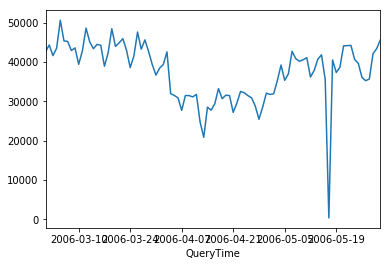

In [26]:
#Plots to find interesting insights
dsChallengeDF.groupby(dsChallengeDF['QueryTime'].dt.date).size().plot()
#The plot shows a dip in the number of queries on a day. Maintence activities on the search or downtime due to other issues could be the reason for the drop 



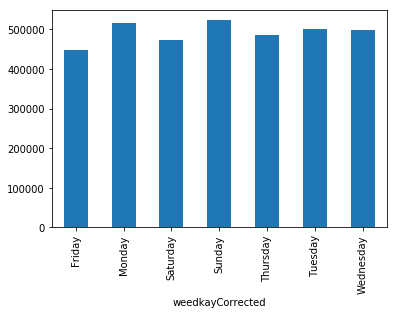

In [27]:
dsChallengeDF.groupby(dsChallengeDF['weedkayCorrected']).size().plot(kind='bar')
#The plot shows the highest number of searches occured on "Sundays" followed by "Monday". More ads on these days are recommended 


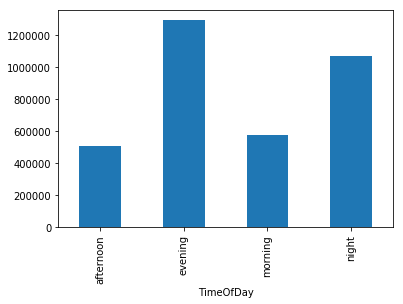

In [28]:
dsChallengeDF.groupby(dsChallengeDF['TimeOfDay']).size().plot(kind='bar')
#The plot shows the highest number of searches occured in the "evening" followed by "night". More ads during evening time is beneficial 



In [22]:
print("Percentage of searches with spelling mistakes:",(dsChallengeDF['is_missSpelled'].sum()/dsChallengeDF.shape[0])*100)

dsChallengeDF.groupby([dsChallengeDF['weedkayCorrected'],dsChallengeDF['Click']]).size()
#Sunday and Monday have the highest number of instances of user clicking on the url



Percentage of searches with spelling mistakes: 36.73111570983095


weedkayCorrected  Click
Friday            0        213345
                  1        235623
Monday            0        243922
                  1        273600
Saturday          0        225247
                  1        249248
Sunday            0        249686
                  1        273631
Thursday          0        241456
                  1        245444
Tuesday           0        253080
                  1        247147
Wednesday         0        240505
                  1        259268
dtype: int64

In [23]:
dsChallengeDF.groupby([dsChallengeDF['TimeOfDay'],dsChallengeDF['Click']]).size()
#EVening time has the highest number of instances of user clicking on the url



TimeOfDay  Click
afternoon  0        244611
           1        265429
evening    0        637322
           1        658475
morning    0        264665
           1        309085
night      0        520643
           1        550972
dtype: int64

In [24]:
dsChallengeDF.groupby([dsChallengeDF['NumOfWords'],dsChallengeDF['Click']]).size()
#lesser the number of words in the search higher, the instances of navigating to the url

NumOfWords  Click
1           0        789666
            1        478062
2           0        390703
            1        477884
3           0        221440
            1        371889
4           0        122203
            1        224427
5           0         65826
            1        117945
6           0         34400
            1         56824
7           0         17771
            1         27604
8           0          9456
            1         13316
9           0          5544
            1          6871
10          0          3207
            1          3838
11          0          1825
            1          2043
12          0          1175
            1          1145
13          0           802
            1           609
14          0           522
            1           386
15          0           394
            1           270
                      ...  
59          0            15
60          0             8
61          0             3
62          0             5
63

In [29]:
#e) Queries leading to click

df1 = dsChallengeDF[['Query','ItemRank','NumOfWords','is_missSpelled']]
df1= df1.loc[df1['is_missSpelled']==0]
df1 = df1.loc[df1['NumOfWords'] <5]
df1.sort_values(['NumOfWords']).head(20)
#Queries that have  NumOfWords <5 always lead to click

#f) Which queries doen't seem to have relevant results
df = dsChallengeDF[['Query','ItemRank','NumOfWords']]
df.sort_values(['ItemRank'], ascending = False).head(20)
#Those queries that have higher rank don't seem to have relevant results


In [32]:
#c) common queries
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in dsChallengeDF['Query']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

#The most common queries are Google, Ebay, Yahpp, myspace, and mapquest#d) 


KeyboardInterrupt: 

In [ ]:
#d) Queries leading to no click
dsChallengeDF.groupby([dsChallengeDF['NumOfWords'],dsChallengeDF['Click']]).size()
dsChallengeDF.groupby([dsChallengeDF['is_missSpelled'],dsChallengeDF['Click']]).size()
df = dsChallengeDF[['Query','ItemRank','NumOfWords','Click']]
df.sort_values(['ItemRank']).head(10)
#Only 14% of the queries that are misspelled had clicks
#Queries that has number of words higher than 10 and queries that have spelling mistakes
#Queries with Item Rank 0 has always led to a click


In [ ]:
#e) Queries leading to click

df1 = dsChallengeDF[['Query','ItemRank','NumOfWords','is_missSpelled']]
df1= df1.loc[df1['is_missSpelled']==0]
df1 = df1.loc[df1['NumOfWords'] <5]
df1.sort_values(['NumOfWords']).head(20)
#Queries that have  NumOfWords <5 always lead to click


In [ ]:
#f) Which queries doen't seem to have relevant results
df = dsChallengeDF[['Query','ItemRank','NumOfWords']]
df.sort_values(['ItemRank'], ascending = False).head(20)
#Those queries that have higher rank don't seem to have relevant results


In [ ]:
#h)common URL
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in dsChallengeDF['ClickURL']: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords, 
            min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

#Websites such as ... are the commonly searched websites

In [ ]:
#Clustering Analysis

#a) How will I cluster users?
#Potential respondants to advertisements vs others
#Based on the time of the day - Active hours - Students - evening/night, kids - Afternoon and evening,
#housewife - Afternoon and evening
#those who search with short query vs long query
#Based on the search content - Queries have to categorized into eg. kids search, teenager, adult


#b) Features considered
#I will consider the following features
#Time of the day, 
#number of words in a query
#Misspelled or not


#c) Clustering algorithm
#I will use kmeans clustering as it doesn't require our data to be distributed normally
#It is the most effective algorithm
#Easy to implement
#Works well with ordinal and nominal data too


#d)Choosing the right number of clusters
#I will use Elbow method to choose the optimum number of clusters
#Elbow method -> sum of square errors -vs number of clusters


#e) Distance metrics for clustering
#I will use Mahalanobis distance
#It takes covariance into consideration which lead tp elliptical decision boundaries
#Euclidean distance works well in a dataset which contains same units across all the input variables



In [ ]:
#Classification
def timeOfDay1(x):
    if x>6 and x<=11:
        return "0"
    elif x>11 and x <15:
        return "1"
    elif x>=15 and x <=20:
        return "2"
    else: 
        return "3"
    
dsChallengeDF['TimeOfDayCorrected'] = dsChallengeDF['QueryTime'].dt.hour.apply(lambda row: timeOfDay1(row))    
#Creation of a column with Number of words in the query as values

xFrame = dsChallengeDF[['NumOfWords','is_missSpelled','weekday','TimeOfDayCorrected']]

yFrame = dsChallengeDF[['Click']]

#TrainTest Split
xTrain, xTest, yTrain, yTest = train_test_split(xFrame, yFrame, test_size = 0.2, random_state = 0)

#Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf = clf.fit(xTrain, yTrain)
y_pred = clf.predict(xTest)
y_pred = pd.DataFrame(y_pred)
confusion_matrix(yTest, y_pred)
tn, fp, fn, tp = confusion_matrix(yTest, y_pred).ravel()

print('Accuracy:',(tp+tn)/(tp+tn+fp+fn))
print('sensitivity:', (tp/(tp+fn)))
print('Specificity:', (tn/(tn+fp)))

#Accuracy of the prediction model is 60.6%
#Sensitivity is good
#specificity is relatively low
#That is only 47% of the click not occuring condition has been captured out of the entire dataset.

#b)
#I have dereived features such as 
    #NumOfWords and is_missSpelled from "Query", 
    #weekday and TimeOfDayCorrected from "QueryTime"
#for the analysis
    

#c) I consider multiple factors while deciding on the right models to build. They are
    #Data type of the target variable
    #Linearity of the data
    #Data type of the input variables
    #Distribution of the target variable
    #balance of the data
	#Distribution of the error 
    
    
#d) I use k fold cross validation method with k value as 5.
    
    
#e) Metrics to support the reliability of the model:
    #R Squared
    #Accuracy of the model
    #Sensitivity
    #Specificity
    #Precision
    #ROC curve
    #p-value
        